# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Query-Data" data-toc-modified-id="Query-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Query Data</a></div><div class="lev1 toc-item"><a href="#visualize-some-stuff" data-toc-modified-id="visualize-some-stuff-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>visualize some stuff</a></div>

In [1]:
import requests as rq
import pandas as pd
import matplotlib.pyplot as mpl
import bs4
import os

from tqdm import tqdm_notebook

from datetime import time

In [2]:
%matplotlib inline

# Query Data

Grab schedule page:

In [3]:
base_url = "https://pydata.org"
r = rq.get(base_url + "/berlin2018/schedule/")
bs = bs4.BeautifulSoup(r.text, "html.parser")

Let's query every talk description:

In [4]:
data = {}
for ahref in tqdm_notebook(bs.find_all("a")):
    if 'schedule/presentation' in ahref.get("href"):
        url = ahref.get("href")
    else:
        continue
    data[url] = {}
    resp = bs4.BeautifulSoup(rq.get(base_url + url).text, "html.parser")
    title = resp.find("h2").text
    resp = resp.find_all(attrs={'class':"container"})[1]

    when, who = resp.find_all("h4")
    date_info = when.string.split("\n")[1:]
    day_info = date_info[0].strip()
    time_inf = date_info[1].strip()
    room_inf = date_info[3].strip()[3:]
    speaker = who.find("a").text
    level =  resp.find("dd").text
    abstract = resp.find(attrs={'class':'abstract'}).text
    description = resp.find(attrs={'class':'description'}).text
    data[url] = {
        'day_info': day_info, 
        'title': title,
        'time_inf': time_inf, 
        'room_inf': room_inf, 
        'speaker': speaker, 
        'level': level, 
        'abstract': abstract, 
        'description': description
    }

Okay, make a dataframe and add some helpful columns:

In [5]:
df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(drop=True, inplace=True)

# Tutorials on Friday
df.loc[df.day_info=='Friday', 'tutorial'] = True
df['tutorial'].fillna(False, inplace=True)

# time handling
df['time_from'], df['time_to'] = zip(*df.time_inf.str.split(u'\u2013'))
df.time_from = pd.to_datetime(df.time_from).dt.time
df.time_to = pd.to_datetime(df.time_to).dt.time
del df['time_inf']

df.to_json('./data.json')

df.head(3)

,day_info,speaker,room_inf,title,abstract,level,description,tutorial,time_from,time_to
0,Friday,Andreas Merentitis,Track 1,Using GANs to improve generalization in a semi...,In this tutorial we will briefly introduce GAN...,Intermediate,In many practical machine learning classificat...,True,09:00:00,10:30:00
1,Friday,Em Grasmeder,Track 2,A Hands-On Introduction to Your First Data Sci...,Software developers interested in getting star...,Intermediate,We’ve created a playground data science applic...,True,13:15:00,14:45:00
2,Friday,Gerrit Gruben,Track 2,Leveling up your storytelling and visualizatio...,\nOverview: Visualization libraries of Python\...,Novice,Not only do you have to master computer system...,True,10:45:00,12:15:00


In [6]:
# Example: Let's query all non-novice talks on sunday, starting at 4 pm
tmp = df.query("(level!='Novice') & (day_info=='Sunday')")
tmp[tmp.time_from >= time(16)]

,day_info,speaker,room_inf,title,abstract,level,description,tutorial,time_from,time_to
11,Sunday,Valentin Haenel,Audimax,Battle-hardened advice on efficient data loadi...,Getting GPUs fully utilized can be tricky when...,Intermediate,Getting GPUs fully utilized can be tricky when...,False,16:00:00,16:45:00
21,Sunday,Jeremy Tuloup,Kursraum 1,Practical examples of interactive visualizatio...,The Jupyter notebook has been the reference to...,Intermediate,The Jupyter ecosystem already comes with popul...,False,16:00:00,16:45:00


# visualize some stuff

In [7]:
plt.style.use('seaborn-darkgrid')#'seaborn-darkgrid')

In [8]:
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 120

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 11

plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\\usepackage{subdepth}, \\usepackage{type1cm}"
plt.rcParams['text.usetex'] = True

/Users/nico.albers/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


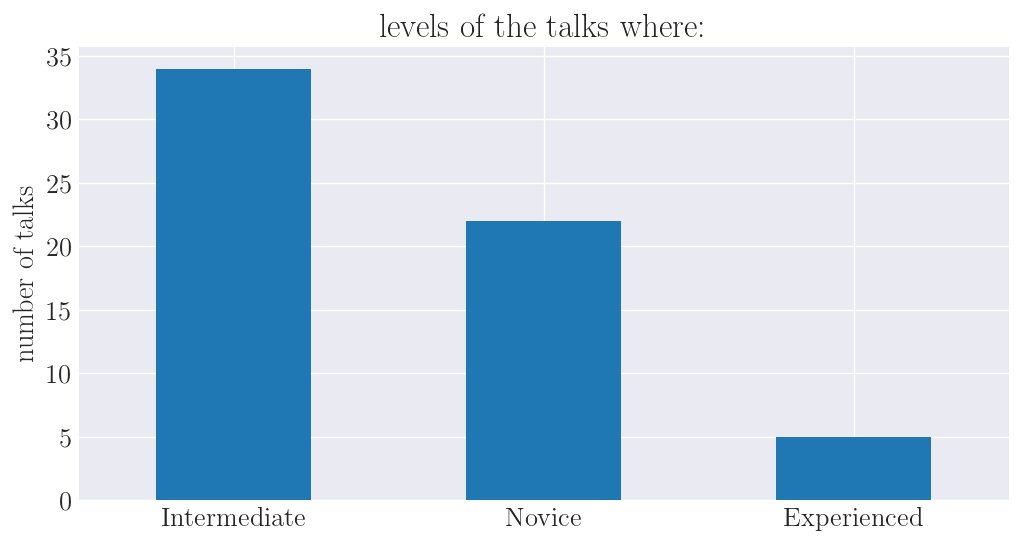

In [9]:
ax = df.level.value_counts().plot.bar(rot=0)
ax.set_ylabel("number of talks")
ax.set_title("levels of the talks where:")
plt.show()

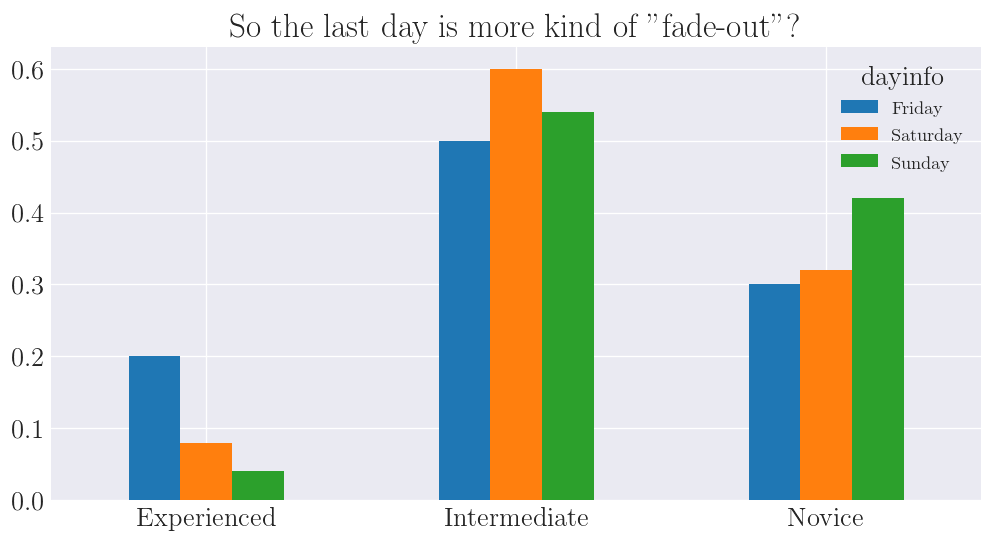

In [11]:
ax = df.rename(columns={'day_info': 'dayinfo'}).groupby("dayinfo")['level'].value_counts(normalize=True).round(2).unstack(level=0).plot.bar(rot=0)
ax.set_xlabel('')
ax.set_title('So the last day is more kind of "fade-out"?')
plt.show()

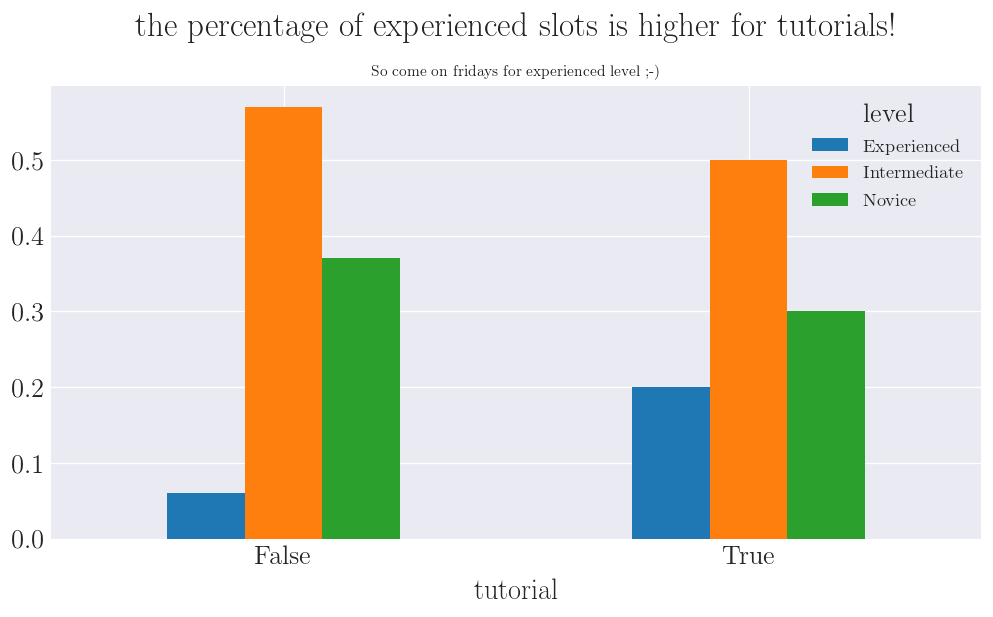

In [12]:
ax = df.groupby("tutorial")['level'].value_counts(normalize=True).round(2).unstack(level=0).T.plot.bar(rot=0)
ax.set_title('the percentage of experienced slots is higher for tutorials!\n\\small{So come on fridays for experienced level ;-)}')
plt.show()